# RNN - Time Series

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0) 

In [3]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [4]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7) 

In [5]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY) 

In [6]:
a = [1, 2, 3, 4, 5]
b = a[::-1]
a, b

([1, 2, 3, 4, 5], [5, 4, 3, 2, 1])

In [7]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY) 

In [8]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [9]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 

In [10]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    if i%10 == 9:
        print(i+1, loss.item())

10 0.049023859202861786
20 0.018011242151260376
30 0.005920967552810907
40 0.003510983195155859
50 0.003522352082654834
60 0.0027159478049725294
70 0.002595387864857912
80 0.0024320511147379875
90 0.002307177521288395
100 0.0022180916275829077
110 0.002139106160029769
120 0.002071348950266838
130 0.002012800658121705
140 0.001960878726094961
150 0.001914135180413723
160 0.0018715683836489916
170 0.0018324143020436168
180 0.0017961073899641633
190 0.001762229367159307
200 0.00173047068528831
210 0.0017005885019898415
220 0.0016723922453820705
230 0.001645726733841002
240 0.0016204642597585917
250 0.0015964965568855405
260 0.0015737316571176052
270 0.0015520896995440125
280 0.0015314985066652298
290 0.001511891488917172
300 0.0014932048507034779
310 0.0014753754949197173
320 0.001458343700505793
330 0.0014420467196032405
340 0.001426428440026939
350 0.0014114396180957556
360 0.001397048938088119
370 0.001383255235850811
380 0.0013701001880690455
390 0.0013576659839600325
400 0.0013460633

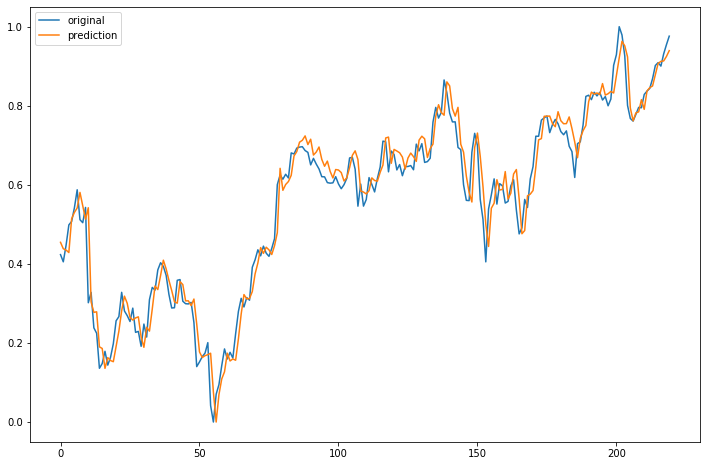

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show() 